# Brain Tumor Classification with CNN and EfficientNetB3

This notebook demonstrates a professional deep learning workflow for classifying brain tumor MRI images into four categories using transfer learning and interpretability techniques.

- **Dataset**: MRI images (see `dataset_link.txt`)
- **Model**: EfficientNetB3 + custom dense layers
- **Metrics**: Accuracy, Precision, Recall, F1-score
- **Interpretability**: Grad-CAM visualizations

> For details, see the accompanying `README.md` file.

In [ ]:
# --- Import Libraries ---
# All required libraries for data loading, visualization, modeling, and evaluation
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# --- Data Loading ---
# Loads training and testing datasets from directory structure
train_dir = 'Training'
test_dir = 'Testing'

img_size = (224, 224)
batch_size = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,
    shuffle=False
)

class_names= train_data.class_names
print("Class names:", class_names)


Found 5712 files belonging to 4 classes.
Found 1283 files belonging to 4 classes.


['glioma', 'meningioma', 'notumor', 'pituitary']

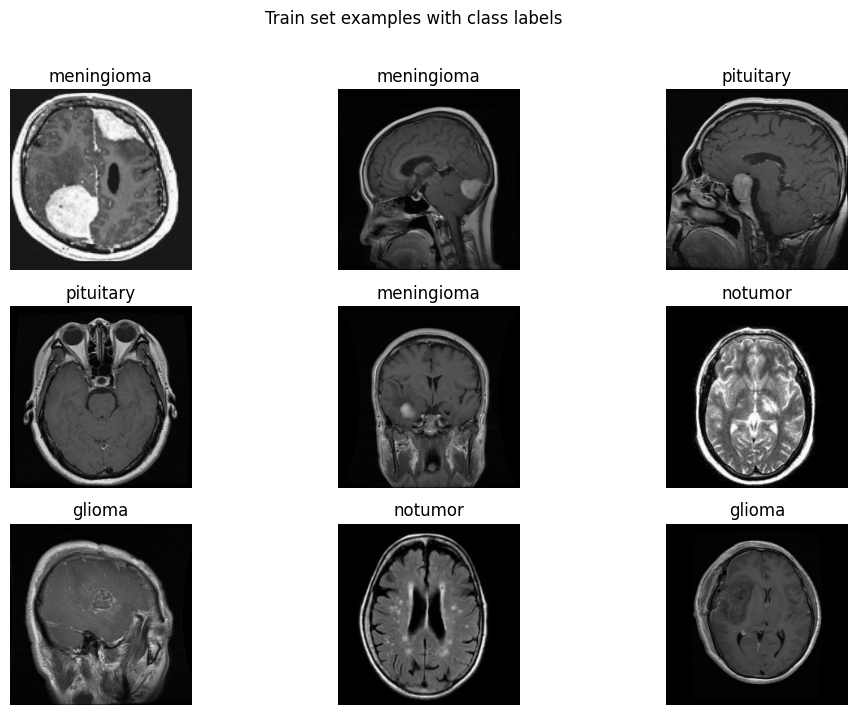

In [ ]:
# --- Data Visualization: Example Images ---
# Shows 9 random images and their class labels for visual inspection
plt.figure(figsize=(12, 8))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_idx = np.argmax(labels[i]) 
        plt.title(class_names[class_idx])
        plt.axis("off")
plt.suptitle("Train set examples with class labels")
plt.show()


C:\Users\emir_\AppData\Local\Temp\ipykernel_22308\2918354486.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=all_labels, palette="viridis")


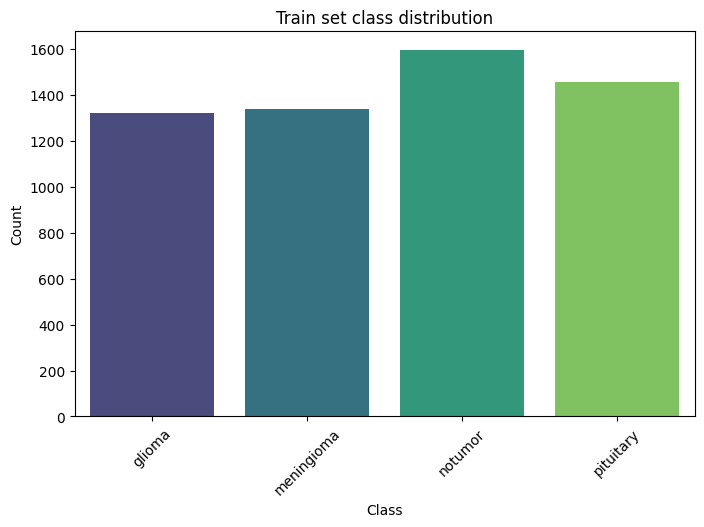

glioma: 1321
meningioma: 1339
notumor: 1595
pituitary: 1457


In [ ]:
# --- Data Analysis: Class Distribution ---
# Shows if the dataset is balanced or imbalanced
all_labels = []
for _, labels in train_data.unbatch():
    all_labels.append(np.argmax(labels.numpy()))
all_labels = np.array(all_labels)

plt.figure(figsize=(8,5))
sns.countplot(x=all_labels, palette="viridis")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.title("Train set class distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

for idx, name in enumerate(class_names):
    print(f"{name}: {(all_labels == idx).sum()}")


In [ ]:
# --- Model Architecture ---
# Uses EfficientNetB3 as feature extractor, with custom dense layers for classification
inputs = tf.keras.Input(shape=img_size + (3,))
base_model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False, 
    weights="imagenet", 
    input_tensor=inputs, 
    pooling='max'
)
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# --- Callbacks for best model saving and learning rate scheduling ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_weights_balanced.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Training the EfficientNetB3-based model...")

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    callbacks=[checkpoint, lr_scheduler, early_stopper],
)


Hassasiyeti artırılmış 'Altın Orta Yol' modeli eğitiliyor...
Epoch 1/10
179/179 [==============================] - 52s 247ms/step - loss: 0.5738 - accuracy: 0.7981 - val_loss: 0.4713 - val_accuracy: 0.8223 - lr: 1.0000e-04
Epoch 2/10
179/179 [==============================] - 43s 238ms/step - loss: 0.1999 - accuracy: 0.9300 - val_loss: 0.2837 - val_accuracy: 0.8979 - lr: 1.0000e-04
Epoch 3/10
179/179 [==============================] - 43s 238ms/step - loss: 0.1118 - accuracy: 0.9596 - val_loss: 0.1964 - val_accuracy: 0.9400 - lr: 1.0000e-04
Epoch 4/10
179/179 [==============================] - 43s 239ms/step - loss: 0.0626 - accuracy: 0.9781 - val_loss: 0.0456 - val_accuracy: 0.9836 - lr: 1.0000e-04
Epoch 5/10
179/179 [==============================] - 42s 237ms/step - loss: 0.0492 - accuracy: 0.9837 - val_loss: 0.0696 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 6/10
179/179 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9919
Epoch 6: ReduceLROnPlateau reduci

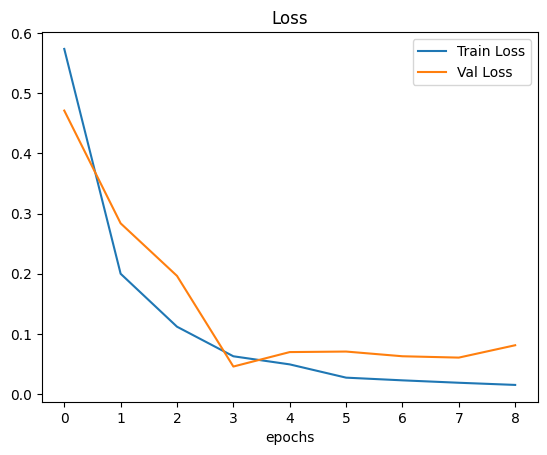

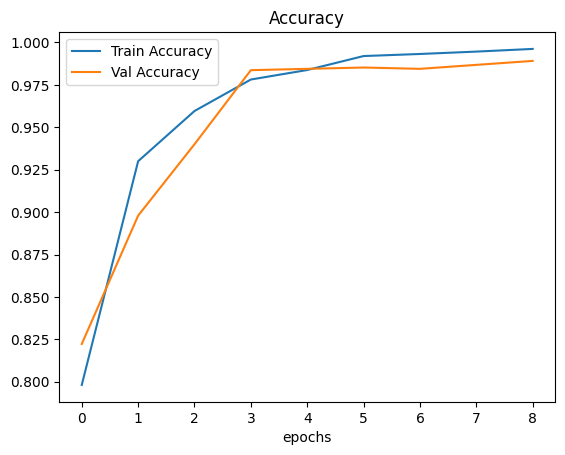

In [ ]:
# --- Training Curves ---
# Shows loss and accuracy curves for both train and validation sets
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(len(train_loss))

plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.legend()
plt.figure()
plt.plot(epochs, train_accuracy, label="Train Accuracy")
plt.plot(epochs, val_accuracy, label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()


Modelin en iyi ağırlıkları 'best_weights_balanced.h5' dosyasından yükleniyor...
Ağırlıklar başarıyla yüklendi.
------------------------------------------------------------
Test verisi üzerinde Loss ve Accuracy hesaplanıyor...
Test Loss: 0.0456
Test Accuracy: 0.9836
------------------------------------------------------------
Tahminler ve gerçek etiketler toplanıyor...
41/41 [==============================] - 3s 51ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       272
  meningioma       0.97      0.97      0.97       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1283
   macro avg       0.98      0.98      0.98      1283
weighted avg       0.98      0.98      0.98      1283

------------------------------------------------------------
Karışıklık Matrisi oluşturuluyor...


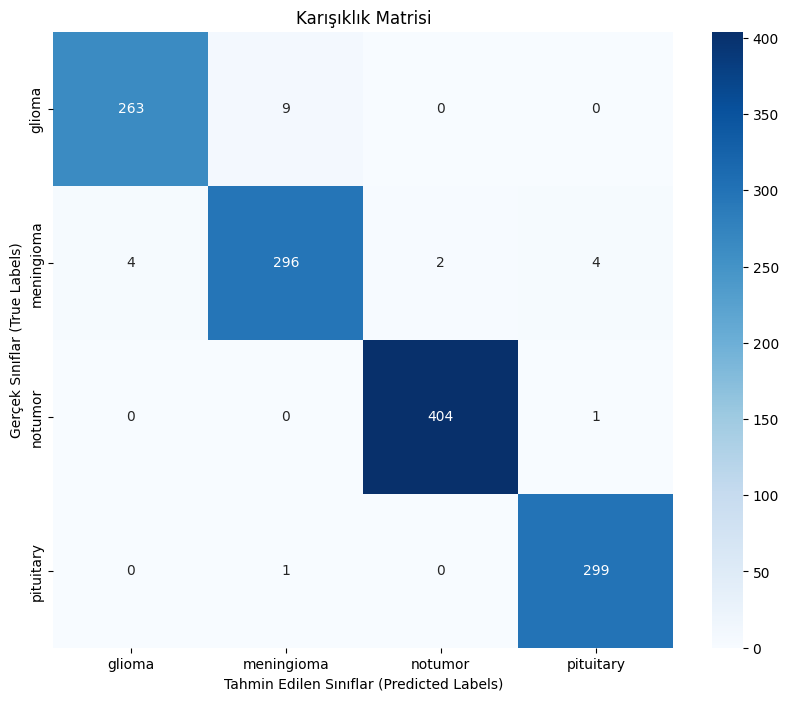

In [ ]:
# --- Model Evaluation: Metrics & Confusion Matrix ---
# Loads best weights, evaluates on test set, prints metrics and confusion matrix
print("Modelin en iyi ağırlıkları 'best_weights_balanced.h5' dosyasından yükleniyor...")
model.load_weights('best_weights_balanced.h5')
print("Ağırlıklar başarıyla yüklendi.")
print("-" * 60)

print("Test verisi üzerinde Loss ve Accuracy hesaplanıyor...")
loss, accuracy = model.evaluate(test_data, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print("-" * 60)

print("Tahminler ve gerçek etiketler toplanıyor...")
y_pred_probs = model.predict(test_data, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for images, labels in test_data:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
print("-" * 60)

print("Karışıklık Matrisi oluşturuluyor...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Karışıklık Matrisi')
plt.ylabel('Gerçek Sınıflar (True Labels)')
plt.xlabel('Tahmin Edilen Sınıflar (Predicted Labels)')
plt.show()


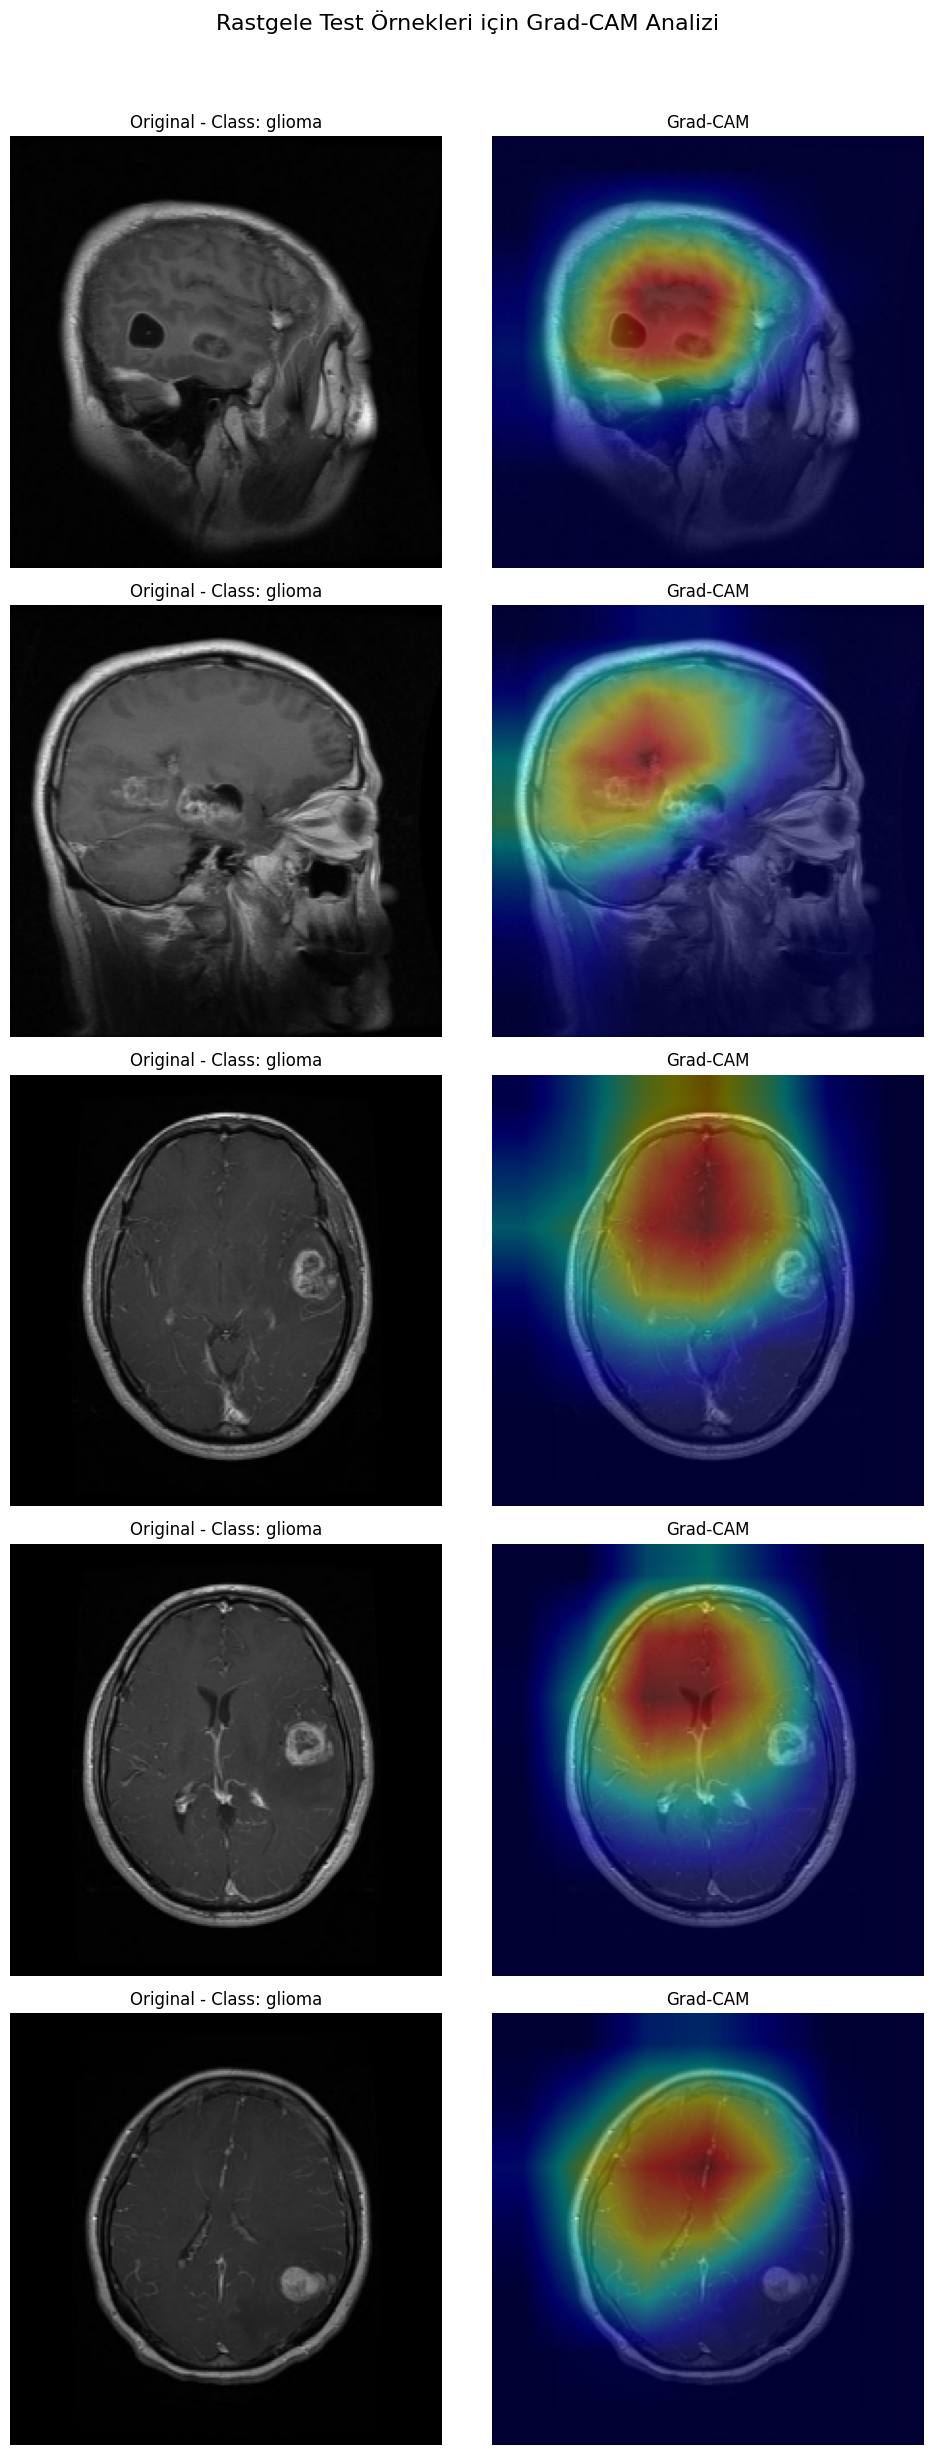

In [ ]:
# --- Model Interpretability: Grad-CAM Visualization ---
# Generates Grad-CAM heatmaps for test images to show model attention

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap for a given image and model."""
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        model.inputs, [last_conv_layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + K.epsilon())
    return heatmap.numpy()

model.load_weights('best_weights_balanced.h5')

# Find last conv layer name automatically for portability
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]

num_images_to_show = 2  # For README, show 2 examples
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 5 * num_images_to_show))
fig.suptitle('Grad-CAM Visualization on Test Images', fontsize=16)
shuffled_test_data = test_data.shuffle(buffer_size=100, reshuffle_each_iteration=True)

for images, labels in shuffled_test_data.take(1):
    for i in range(num_images_to_show):
        img_for_display = images[i].numpy().astype("uint8")
        img_array_for_model = tf.keras.applications.efficientnet.preprocess_input(np.expand_dims(images[i], axis=0))
        heatmap = make_gradcam_heatmap(img_array_for_model, model, last_conv_layer_name)
        heatmap = cv2.resize(heatmap, (img_for_display.shape[1], img_for_display.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(img_for_display, 0.6, heatmap, 0.4, 0)
        axes[i, 0].imshow(img_for_display)
        axes[i, 0].set_title(f"Original - Class: {class_names[np.argmax(labels[i])]}")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        axes[i, 1].set_title('Grad-CAM')
        axes[i, 1].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
